<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/DenseNet(torch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1. 패키지 로드
---

In [ ]:
!pip install --upgrade albumentations

  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Using cached opencv_python_headless-4.5.3.56-cp37-cp37m-manylinux2014_x86_64.whl (37.1 MB)
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A
import torch.nn as nn
import math
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib inline 

#device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
# 2. 논문 분석

이전의 resnet 및 CNN구조들을 분석하여, pre-active resnet과 비슷한 효과를 낼 수 있는 새로운 방법으로 제안하는 논문

* 핵심 구조
* 장점
* 이전 연구와 차이



---

## 1) 핵심 구조


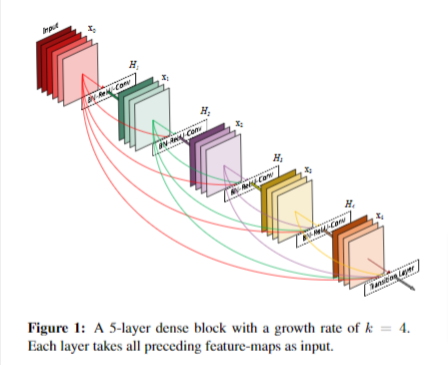

* 이 구조가 DenseNet의 핵심 아이디어이다. 이는 DenseBlcok이라 불리는데, 5개의 레이어의 각각의 아웃풋이 이 후 모든 연산에 더해지는 것이다. 따라서 보통 이전에는 피드포워드가 단순히 이전 레이어와 L개의 연결로 이뤄졌다면, 이제는 연결수가 처음부분부터 끝까지 계속 늘어나므로 L(L+1)/2 이다.

* 이 연산이 기존의 resnet이 제안한 shortcut과 다른 점은 단순히 add 연산을 하는 것이 아니라, concatenation연산으로 채널을 쌓는 다는 점이다. 이에 대한건 아래에 설명

* 그 외의 다른 구조, 블럭은 전부 위의 구조에 맞추기 위해 채널수, 이미지 크기등등을 조정하는 것

## 2) 장점

1. alleviate the vanishing-gradient problem
 > 직관적으로 이해 가능. resnet과 비슷한 원리라 생각

2. strengthen feature propagation
> 이전의 shortcut은 그저 add를 하니까 feature들이 섞이는데, 이 구조는 명시적으로 층을 구분하니까 feature를 명확히 구분하여 전달함.

3. encourage feature reuse
> 이전 피쳐를 더하는게 아니라 그대로 재사용하는 방법을 제시, 게다가 모든 연산에서 계속 더해지므로 피쳐맵들을 여러번 재사용하는 것

4. substantially reduce the number of parameters. 
> 직관적으로 생각하면 계속 층이 더해지니까 param과 계산량이 크게 늘 것 같지만,  중복되는 feature를 다시 학습 할 필요가 없으므로 오히려 채널 수를 더 줄일 수 있다.

3) ResNet과 비교

위에서 설명했듯이 add와 concatenation의 차이이다. 논문의 주장으로는 summation(add)로 결합되는 것은 오히려 정보의 흐름을 방해 할 수 있다고 한다.

아래는 두 식

image.png

image.png



---


# 3. 구현




---







## 기본구조 구현

In [ ]:
def conv_block(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1 , **kwargs) :
    """ 
    conv들이 기본적으로 ReLU를 가지고 있고,
    성능향상을 위해서 BN층도 추가하여 block으로 만든다.
    BN을 사용하므로 bias는 False로 둔다.
    """
    output = nn.Sequential(
       nn.Conv2d(in_channels, out_channels, kernel_size ,stride, padding ,bias =False, **kwargs),
       nn.BatchNorm2d(out_channels),
       nn.ReLU()
    )
    return output

## DenseBlock

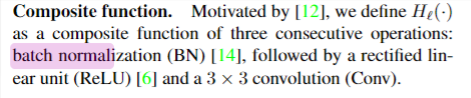

기본 구조가 이전과 달리 BN > ReLU > Conv 순이다.  결국 길게 펴서보면 동일한순서지만, 아마 pre-activation 과 비슷한 효과를 보기위해서 인듯. 또한 논문 아래쪽에 처음을 제외한 모든 conv 이 후 0.2 dropout을 적용했다고 써있음.

In [ ]:
class DenseConv(nn.Module):
    '''
    기본버전 말고 bottleneck 버전 구현.
    독특한점이 4배로 늘렸다가 줄임.

    block마다 입력을 같이 더해서 출력하면
    결국 마지막 block 까지 출력이 쌓여가며 더해진다.
    '''

    def __init__(self, in_channels, out_channels):
        super(DenseConv, self).__init__()

        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels*4, 1,1, bias=False),
            nn.Dropout(0.2),

            nn.BatchNorm2d(in_channels*4),
            nn.ReLU(),
            nn.Conv2d(in_channels*4, out_channels,3,1,1, bias=False),
            nn.Dropout(0.2)
        )
    def forward(self, x):
        out = self.conv1(x)
        output = [x, out]
        return torch.cat(output,1)

growth_rate는 한 단계마다 늘어나는 채널수

num_block은 블럭의 수

In [ ]:
class DenseBlock(nn.Module):
    '''
    growth_rate는 한 단계마다 늘어나는 채널수
    num_block은 기본블럭의 반복수
    '''
    def __init__(self, num_block, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_block):
            layers.append(DenseConv(in_channels+i*growth_rate, growth_rate))

        self.block_layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.block_layer(x)

## TrasitionBlock

In [ ]:
class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1,1, bias=False),
            nn.Dropout(0.2),
            nn.AvgPool2d(2,2)
        )        

    def forward(self, x):
        out = self.conv1(x)

        return out

## DenseNet

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, num_classes=1000, growth_rate = 12):
        super(DenseNet, self).__init__()

        in_channels = growth_rate*2
        self.bottom = nn.Sequential(
            nn.Conv2d(3, in_channels, 7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, 1)
        )

        self.dense1 = DenseBlock(6,in_channels,growth_rate)
        in_channels += growth_rate * 6        
        self.trans1 = TransitionBlock(in_channels, in_channels//2)
        in_channels = in_channels//2

        self.dense2 = DenseBlock(12,in_channels,growth_rate)
        in_channels += growth_rate * 12        
        self.trans2 = TransitionBlock(in_channels, in_channels//2)
        in_channels = in_channels//2

        self.dense3 = DenseBlock(32,in_channels,growth_rate)
        in_channels += growth_rate * 32
        self.trans3 = TransitionBlock(in_channels, in_channels//2)
        in_channels = in_channels//2

        self.dense4 = DenseBlock(32,in_channels,growth_rate)
        in_channels += growth_rate * 32

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, num_classes)
        )
        

        self._initialize_weights()
    


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



    def forward(self, input_tensor):
        x = self.bottom(input_tensor)
        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.trans2(x)
        x = self.dense3(x)
        x = self.trans3(x)
        x = self.dense4(x)       
        x = self.classifier(x)
        return x



In [ ]:
# # 모델 확인
# model = DenseNet().to(device)
# summary(model, (3,96,96))
    

---
# 4. 데이터 전처리
---

## 데이터 로드
 * 이미지 채크
 * STL10 (3,96,96)의 토치형식


In [ ]:
trainset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform= transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = trainset.classes

In [ ]:
batch_size = 7
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = trainset.classes
# 클래스 정보 가져오기

In [ ]:
# trainloader.

In [ ]:
# 이미지를 보여주기 위한 함수
def show_images(images, labels, ncols=4):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.transpose(images[i], (1, 2, 0)))
        # 차원이 바뀌므로 바꿔줘야함
        axs[i].set_title(classes[labels[i]])

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
labels.shape

torch.Size([7])

(3, 96, 96)
torch.Size([3, 96, 96])


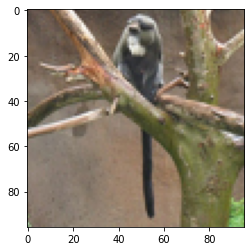

In [ ]:
# 잘 들어왔나 확인
# plt.imshow(trainset.data[1])
# STL은 애초에 데이터셋 자체가 텐서형식임((3, 96, 96))
# Totensor(데이터 로더를 통해)하면 알아서 차원까지 transpose해줌.
# cifar 경우 32 32 3 임. plt가 32,32,3 으로 받기 때문에 plt 통해 출력하려면 transpose가 필요
plt.imshow(np.transpose(trainset.data[1], (1, 2, 0)))

print(trainset.data[1].shape)
print(images[1].shape)

In [ ]:
print(trainset.data[1][1,:3,0:3])
print(images[1][1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1]/255)[1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1])[1,:3,0:3])
# trainloader의 trasform을 거치는 것 만으로 0~1로 정규화된다.
# 아래 transform에서 평균과 표준편차로 나누는 것은 정확히는 표준화이다.
# totensor를 거치면 자동으로 0~1로 정규화 된다. 그리고 totensor 안에 transpose도 들어있는듯
# totensor안에 정규화가 들어있는데, 값이 이미 정규화되어있으면 하지 않음. 3,4번 라인비교


[[73 81 89]
 [71 79 86]
 [64 77 80]]
tensor([[0.2863, 0.3176, 0.3490],
        [0.2784, 0.3098, 0.3373],
        [0.2510, 0.3020, 0.3137]])
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]], dtype=torch.float64)
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]])


In [ ]:
# 아래처럼, loader안에 transpose 후 totensor하면 원하던 차원순서 312가 나옴
testnp = np.zeros((3,1,2))
print(testnp.shape)
print(transforms.ToTensor()(testnp).shape)
print(np.transpose(testnp, (1, 2, 0)).shape)
print(transforms.ToTensor()(np.transpose(testnp, (1, 2, 0))).shape)

(3, 1, 2)
torch.Size([2, 3, 1])
(1, 2, 3)
torch.Size([3, 1, 2])


In [ ]:
print(trainset.data[1].shape)
print(images[1].shape)
print(transforms.ToTensor()(trainset.data[1]).shape)

# totansor뿐만아니라 loader까지 거쳐야 원하는 차원으로 나오는듯
# 아마 로더에 차원 변경이 구현되어있는듯
# 아래 커스텀 모델에 이것도 구현해야함.

(3, 96, 96)
torch.Size([3, 96, 96])
torch.Size([96, 3, 96])


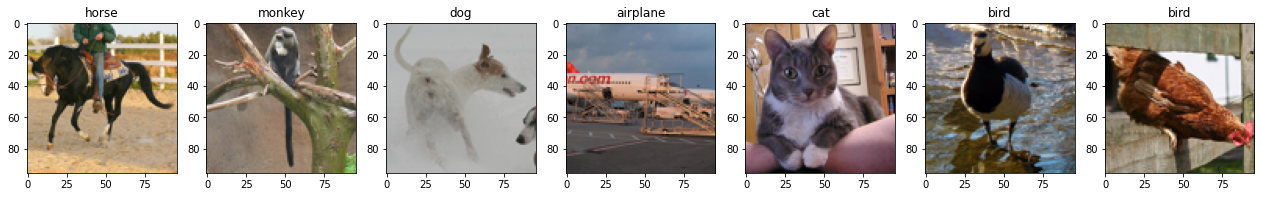

In [ ]:
# 이미지 보여주기
show_images(images,labels,7)

In [ ]:
images[1][1,1,1]

tensor(0.3098)

In [ ]:
aa = np.transpose(trainset.data[1], (1, 2, 0))
print(transforms.ToTensor()(aa).shape)

torch.Size([3, 96, 96])


## 커스텀 데이터셋 구현
* albumentations을 사용하기 위해서 커스텀 데이터 셋을 구현한다.
* 파이토치 텐서플로우 전부 이미지를 배치단위로 cpu,gpu 옮기는 과정에 병목이 있다고 알고있음. 즉, tf나 torch나 데이터 파이프 라인을 그대로 쓰는 것 보다 albumentations을 이용하는 것이 훨씬빠름.




In [ ]:
# 커스텀 데이터(albumenatation 적용)
class ForAlbuSet(Dataset):
    def __init__(self, dataset, transform = None ,data_type = "train" ):
        self.dataset = dataset
        self.transform = transform
        self.data_type = data_type


    def __len__(self):
        return self.dataset.data.shape[0]

    def __getitem__(self, index):
        image = self.dataset.data[index]
        image = np.transpose(image, (1, 2, 0))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 위옵션은 cv2.imread에서 필요함
        label = self.dataset.labels[index]
        # CIFAR에서는 데이터셋 안에 label이 아니라 target으로 적혀있음.
        # CIFAR는 int반환이지만 얘는 numpy.unit8
        # label과 image를 output 결과와 통일 시켜야함(int,long, float, double 등등)
        # 형변환은 train에서 구현 : 데이터셋과 상관없이 항상 필요한 작업

        
        if self.data_type == "train" : 
            # random_n = np.random.randint(148,256)
            # image = cv2.resize(image, (random_n,random_n))
            # resize로 멀티스케일을 작게나마 구현 해보았음
            # 다만 너무 계산시간이 커진다.


            if self.transform is not None:
                image = self.transform(image=image)["image"]        
        else :

            if self.transform is not None:
                image = self.transform(image=image)["image"]


        return image, label
    

## 증강(transform)

* 토치의 transform 사용시에는 to 텐서 다음에 노말 하기. totensor를 해야 값들이 0\~1사이로감. 그래야 imagenet 평균과 표준편차를 사용가능(0\~255가 아니라 0~1이니까)
    > albumentation은 구현코드를 확인해보면, normalize안에 자동으로 255로 나눠서 구현되어있음.


* torchvision.transforms.(채널, 세로, 가로) 과 달리 Albu.transforms 는 array 기준으로 작업함(세로,가로,채널)
* cv2는 (가로,세로,채널)

* (주의) totensor없으면 loader가 작동 안 함.(차원 순서 바뀌기 때문)

* 실험과정에서 성능이 좋지않아서 논문과 다른 장치들을 넣었음.

In [ ]:
augmentor_tr = A.Compose([        
    # A.Resize(232,232),
    # A.Resize(224,224),                
    # A.FancyPCA(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

augmentor_test = A.Compose([
    # A.Resize(224,224),                            
    A.Normalize(),
    ToTensorV2()
])

## 분할

* random_split이 Torch.utils.data.dataset.random_split에도 있는데, 이건 제대로 작동 안 하니까 조심, random_split은 분할을 하지만 원본을 그대로 두고 랜덤인덱스로 불러오는 원리.아마 메모리 관리를 위해 이렇게 구현한듯

* STL10 데이터는 테스트가 8000개고 트레인이 5000개 이다. 테스트가 트레인보다 많으므로, test데이터로 train에쓰고 train 데이터로 테스트에 쓰자. 트레인 데이터가 더 많아야 한다. 
    > 위의 로딩식 수정했음. 
    
* 또한 분할을 이용해서 5000개를 3000/2000으로 나누어 validation과 test를 하자.

In [ ]:
val_ratio = 0.6
val_size = round(len(testset)*val_ratio)
test_size = len(testset) - val_size
                    
val_set, test_set= random_split(
    testset,
    [val_size,test_size],
    generator=torch.Generator().manual_seed(20)
    )

In [ ]:
# 분할 채크
len(val_set)

3000

In [ ]:
ab_train_set = ForAlbuSet(trainset, transform=augmentor_tr)
ab_val_set = ForAlbuSet(val_set.dataset, transform=augmentor_test, data_type= 'val')
ab_test_set = ForAlbuSet(test_set.dataset, transform=augmentor_test, data_type= 'test')


In [ ]:
batch_size = 32
train_loader = DataLoader(ab_train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = DataLoader(ab_val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = DataLoader(ab_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)




---
# 5. 학습 및 평가
---

**구현목표**
* 정확도 metric 구현 
* 로스, 정확도 동시에 출력
* 콜백(reducelr, earlystop)
* 작업진행도 모니터링 출력
* 테스트 loss 변화 그래프로 출력
* train, vaildate, fit 구현



## early stopping class 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')

        self.val_loss_min = val_loss

## train, validate, fit, test 함수 정의

In [ ]:
def train(model,train_loader, criterion, optimizer, epoch):
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for images, target in stream:
        images = images.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()

        output = model(images)
        sum_loss = criterion(output, target)
        loss = sum_loss/len(target)
        # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
        # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.



        loss.backward()
        optimizer.step()

        # 로스합
        train_loss +=sum_loss.item()

        # 정확도 계산
        pred = output.max(dim = 1,keepdim = True)[1]
        correct += (target.view(-1, 1) == pred).sum().item()


        stream.set_description(
            f"Epoch: {epoch}. Train."
        )
        

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [ ]:
def validate(model, val_loader, criterion, epoch):
    model.eval()
    stream = tqdm(val_loader)
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images, target in stream:
            images = images.to(device).float()
            target = target.to(device).long()

            output = model(images)
            sum_loss = criterion(output, target)
            loss = sum_loss/len(target)
            # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
            # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.

            # 로스합
            val_loss +=sum_loss.item()

            # 정확도 계산
            pred = output.max(dim = 1,keepdim = True)[1]
            correct += (target.view(-1, 1) == pred).sum().item()




            stream.set_description(
                f"Epoch: {epoch}. Validate."
            )
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, val_accuracy

In [ ]:
def fit(model,train_loader,val_loader,criterion,optimizer,epoch, early_stopping=None, scheduler=None):
 
    # epoch당 average loss를 track하기 위한 list
    avg_train_losses = []
    avg_val_losses = []
    avg_train_accuracy = []
    avg_val_accuracy = []

    for i in range(1, epoch + 1):
        train_loss ,train_accuracy =train( model,train_loader, criterion, optimizer, i)
        print(f"[{i}] Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        val_loss ,val_accuracy = validate( model,val_loader, criterion, i)
        if i == epoch :
            sleep(0.1)
            # 마지막 출력에서 tqdm이 업데이트 되기전에 아래 출력값이 나오지 않도록.
            # 다른 줄에 아래값이 나올 수 있게 해줌
        print(f"[{i}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


        
        if scheduler is not None :
            # scheduler.step()
            scheduler.step(val_loss) 
            # 아래는 reducelronplateau 전용
            

        avg_train_losses.append(train_loss)
        avg_val_losses.append(val_loss)
        avg_train_accuracy.append(train_accuracy)
        avg_val_accuracy.append(val_accuracy)

        
        if early_stopping is not None :
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print()
                print("Early stopping")
                sleep(0.1)
                break

        print()

                         
    return  model, avg_train_losses, avg_val_losses,  avg_train_accuracy , avg_val_accuracy


In [ ]:
def test(model, test_loader, criterion):
    test_loss ,test_accuracy = validate( model,test_loader, criterion, 1)
    sleep(0.1)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    
    return (test_loss ,test_accuracy)

## 학습

In [ ]:
model = DenseNet(10).to(device)

In [ ]:
# loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(reduction='sum')


# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 스케쥴러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# early_stopping
early_stopping = EarlyStopping(patience = 15, verbose = True)

In [ ]:

model, train_loss, val_loss ,train_accuracy ,val_accuracy= fit(model,train_loader,val_loader,criterion,optimizer,100,early_stopping,scheduler)

  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch: 1. Train.: 100%|██████████| 250/250 [01:10<00:00,  3.52it/s]


[1] Train Loss: 2.2313, Accuracy: 19.44%


Epoch: 1. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.33it/s]


[1] Validation Loss: 2.4475, Accuracy: 21.90%
Validation loss decreased (inf --> 2.447545).



Epoch: 2. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[2] Train Loss: 1.9766, Accuracy: 26.46%


Epoch: 2. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.35it/s]


[2] Validation Loss: 1.9669, Accuracy: 31.08%
Validation loss decreased (2.447545 --> 1.966939).



Epoch: 3. Train.: 100%|██████████| 250/250 [01:12<00:00,  3.43it/s]


[3] Train Loss: 1.8893, Accuracy: 29.02%


Epoch: 3. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.26it/s]


[3] Validation Loss: 2.0843, Accuracy: 31.80%
EarlyStopping counter: 1 out of 15



Epoch: 4. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[4] Train Loss: 1.8184, Accuracy: 30.61%


Epoch: 4. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.15it/s]


[4] Validation Loss: 1.9202, Accuracy: 33.42%
Validation loss decreased (1.966939 --> 1.920242).



Epoch: 5. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[5] Train Loss: 1.7862, Accuracy: 31.85%


Epoch: 5. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.23it/s]


[5] Validation Loss: 1.9786, Accuracy: 33.02%
EarlyStopping counter: 1 out of 15



Epoch: 6. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[6] Train Loss: 1.7397, Accuracy: 34.16%


Epoch: 6. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.30it/s]


[6] Validation Loss: 1.9578, Accuracy: 34.60%
EarlyStopping counter: 2 out of 15



Epoch: 7. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[7] Train Loss: 1.7107, Accuracy: 35.69%


Epoch: 7. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.20it/s]


[7] Validation Loss: 2.0418, Accuracy: 34.14%
EarlyStopping counter: 3 out of 15



Epoch: 8. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[8] Train Loss: 1.6646, Accuracy: 37.46%


Epoch: 8. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.31it/s]


[8] Validation Loss: 2.0553, Accuracy: 33.92%
EarlyStopping counter: 4 out of 15



Epoch: 9. Train.: 100%|██████████| 250/250 [01:12<00:00,  3.43it/s]


[9] Train Loss: 1.6436, Accuracy: 38.20%


Epoch: 9. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.25it/s]


[9] Validation Loss: 2.0463, Accuracy: 35.48%
EarlyStopping counter: 5 out of 15



Epoch: 10. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[10] Train Loss: 1.6313, Accuracy: 39.29%


Epoch: 10. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.26it/s]


[10] Validation Loss: 2.0869, Accuracy: 33.60%
EarlyStopping counter: 6 out of 15



Epoch: 11. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[11] Train Loss: 1.6213, Accuracy: 38.80%


Epoch: 11. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.26it/s]


[11] Validation Loss: 1.7846, Accuracy: 38.54%
Validation loss decreased (1.920242 --> 1.784645).



Epoch: 12. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[12] Train Loss: 1.6055, Accuracy: 40.51%


Epoch: 12. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.35it/s]


[12] Validation Loss: 1.9597, Accuracy: 36.10%
EarlyStopping counter: 1 out of 15



Epoch: 13. Train.: 100%|██████████| 250/250 [01:12<00:00,  3.43it/s]


[13] Train Loss: 1.5529, Accuracy: 41.84%


Epoch: 13. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.27it/s]


[13] Validation Loss: 1.8960, Accuracy: 36.50%
EarlyStopping counter: 2 out of 15



Epoch: 14. Train.: 100%|██████████| 250/250 [01:12<00:00,  3.43it/s]


[14] Train Loss: 1.5606, Accuracy: 41.42%


Epoch: 14. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.27it/s]


[14] Validation Loss: 1.8664, Accuracy: 39.02%
EarlyStopping counter: 3 out of 15



Epoch: 15. Train.: 100%|██████████| 250/250 [01:12<00:00,  3.43it/s]


[15] Train Loss: 1.5367, Accuracy: 42.92%


Epoch: 15. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.35it/s]


[15] Validation Loss: 1.7099, Accuracy: 40.90%
Validation loss decreased (1.784645 --> 1.709922).



Epoch: 16. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[16] Train Loss: 1.5187, Accuracy: 43.48%


Epoch: 16. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.27it/s]


[16] Validation Loss: 1.7854, Accuracy: 40.70%
EarlyStopping counter: 1 out of 15



Epoch: 17. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.40it/s]


[17] Train Loss: 1.4951, Accuracy: 45.25%


Epoch: 17. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.46it/s]


[17] Validation Loss: 1.8244, Accuracy: 39.98%
EarlyStopping counter: 2 out of 15



Epoch: 18. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.38it/s]


[18] Train Loss: 1.4947, Accuracy: 44.70%


Epoch: 18. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.48it/s]


[18] Validation Loss: 1.7016, Accuracy: 42.70%
Validation loss decreased (1.709922 --> 1.701635).



Epoch: 19. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[19] Train Loss: 1.4675, Accuracy: 45.95%


Epoch: 19. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.43it/s]


[19] Validation Loss: 1.8679, Accuracy: 39.64%
EarlyStopping counter: 1 out of 15



Epoch: 20. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.40it/s]


[20] Train Loss: 1.4514, Accuracy: 45.70%


Epoch: 20. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.47it/s]


[20] Validation Loss: 1.6711, Accuracy: 45.22%
Validation loss decreased (1.701635 --> 1.671110).



Epoch: 21. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.41it/s]


[21] Train Loss: 1.4349, Accuracy: 47.21%


Epoch: 21. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.49it/s]


[21] Validation Loss: 1.8502, Accuracy: 40.86%
EarlyStopping counter: 1 out of 15



Epoch: 22. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[22] Train Loss: 1.4322, Accuracy: 47.14%


Epoch: 22. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.44it/s]


[22] Validation Loss: 1.6604, Accuracy: 45.08%
Validation loss decreased (1.671110 --> 1.660426).



Epoch: 23. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[23] Train Loss: 1.4177, Accuracy: 47.49%


Epoch: 23. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.56it/s]


[23] Validation Loss: 1.7537, Accuracy: 43.80%
EarlyStopping counter: 1 out of 15



Epoch: 24. Train.: 100%|██████████| 250/250 [01:12<00:00,  3.45it/s]


[24] Train Loss: 1.3976, Accuracy: 48.96%


Epoch: 24. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.44it/s]


[24] Validation Loss: 1.9287, Accuracy: 41.60%
EarlyStopping counter: 2 out of 15



Epoch: 25. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[25] Train Loss: 1.3810, Accuracy: 49.05%


Epoch: 25. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.43it/s]


[25] Validation Loss: 1.7127, Accuracy: 44.50%
EarlyStopping counter: 3 out of 15



Epoch: 26. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[26] Train Loss: 1.3596, Accuracy: 49.71%


Epoch: 26. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.41it/s]


[26] Validation Loss: 1.7588, Accuracy: 43.82%
EarlyStopping counter: 4 out of 15



Epoch: 27. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[27] Train Loss: 1.3617, Accuracy: 49.99%


Epoch: 27. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.42it/s]


[27] Validation Loss: 1.5924, Accuracy: 47.34%
Validation loss decreased (1.660426 --> 1.592410).



Epoch: 28. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.42it/s]


[28] Train Loss: 1.3450, Accuracy: 49.80%


Epoch: 28. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.40it/s]


[28] Validation Loss: 1.5721, Accuracy: 49.68%
Validation loss decreased (1.592410 --> 1.572103).



Epoch: 29. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.41it/s]


[29] Train Loss: 1.3344, Accuracy: 50.85%


Epoch: 29. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.37it/s]


[29] Validation Loss: 1.4241, Accuracy: 52.30%
Validation loss decreased (1.572103 --> 1.424105).



Epoch: 30. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


[30] Train Loss: 1.3119, Accuracy: 52.15%


Epoch: 30. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.48it/s]


[30] Validation Loss: 1.5264, Accuracy: 51.70%
EarlyStopping counter: 1 out of 15



Epoch: 31. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[31] Train Loss: 1.3116, Accuracy: 51.76%


Epoch: 31. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.44it/s]


[31] Validation Loss: 1.5577, Accuracy: 50.02%
EarlyStopping counter: 2 out of 15



Epoch: 32. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.37it/s]


[32] Train Loss: 1.3077, Accuracy: 52.58%


Epoch: 32. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.43it/s]


[32] Validation Loss: 1.4964, Accuracy: 51.62%
EarlyStopping counter: 3 out of 15



Epoch: 33. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[33] Train Loss: 1.2944, Accuracy: 52.38%


Epoch: 33. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.48it/s]


[33] Validation Loss: 1.6172, Accuracy: 48.50%
EarlyStopping counter: 4 out of 15



Epoch: 34. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[34] Train Loss: 1.2938, Accuracy: 53.02%


Epoch: 34. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.28it/s]


[34] Validation Loss: 1.7817, Accuracy: 45.86%
EarlyStopping counter: 5 out of 15



Epoch: 35. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[35] Train Loss: 1.2763, Accuracy: 53.96%


Epoch: 35. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.33it/s]


[35] Validation Loss: 1.5855, Accuracy: 49.64%
EarlyStopping counter: 6 out of 15



Epoch: 36. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.38it/s]


[36] Train Loss: 1.2834, Accuracy: 53.29%


Epoch: 36. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.34it/s]


[36] Validation Loss: 1.6073, Accuracy: 50.82%
EarlyStopping counter: 7 out of 15



Epoch: 37. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[37] Train Loss: 1.2487, Accuracy: 54.26%


Epoch: 37. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.27it/s]


[37] Validation Loss: 1.6226, Accuracy: 50.16%
EarlyStopping counter: 8 out of 15



Epoch: 38. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[38] Train Loss: 1.2458, Accuracy: 54.94%


Epoch: 38. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.25it/s]


[38] Validation Loss: 1.4125, Accuracy: 54.18%
Validation loss decreased (1.424105 --> 1.412499).



Epoch: 39. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.40it/s]


[39] Train Loss: 1.2440, Accuracy: 54.12%


Epoch: 39. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.36it/s]


[39] Validation Loss: 1.4119, Accuracy: 53.40%
Validation loss decreased (1.412499 --> 1.411911).



Epoch: 40. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.40it/s]


[40] Train Loss: 1.2107, Accuracy: 55.54%


Epoch: 40. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.24it/s]


[40] Validation Loss: 1.3774, Accuracy: 54.54%
Validation loss decreased (1.411911 --> 1.377384).



Epoch: 41. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


[41] Train Loss: 1.2099, Accuracy: 56.21%


Epoch: 41. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.26it/s]


[41] Validation Loss: 1.2865, Accuracy: 57.30%
Validation loss decreased (1.377384 --> 1.286488).



Epoch: 42. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[42] Train Loss: 1.2125, Accuracy: 56.35%


Epoch: 42. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.26it/s]


[42] Validation Loss: 1.3100, Accuracy: 55.90%
EarlyStopping counter: 1 out of 15



Epoch: 43. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.37it/s]


[43] Train Loss: 1.1976, Accuracy: 56.80%


Epoch: 43. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.27it/s]


[43] Validation Loss: 1.2375, Accuracy: 57.98%
Validation loss decreased (1.286488 --> 1.237515).



Epoch: 44. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


[44] Train Loss: 1.1801, Accuracy: 57.74%


Epoch: 44. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.42it/s]


[44] Validation Loss: 1.3291, Accuracy: 55.62%
EarlyStopping counter: 1 out of 15



Epoch: 45. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.40it/s]


[45] Train Loss: 1.1828, Accuracy: 56.79%


Epoch: 45. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.25it/s]


[45] Validation Loss: 1.4781, Accuracy: 52.94%
EarlyStopping counter: 2 out of 15



Epoch: 46. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[46] Train Loss: 1.1747, Accuracy: 57.66%


Epoch: 46. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.36it/s]


[46] Validation Loss: 1.2889, Accuracy: 57.66%
EarlyStopping counter: 3 out of 15



Epoch: 47. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.40it/s]


[47] Train Loss: 1.1689, Accuracy: 57.96%


Epoch: 47. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.46it/s]


[47] Validation Loss: 1.4248, Accuracy: 53.78%
EarlyStopping counter: 4 out of 15



Epoch: 48. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


[48] Train Loss: 1.1728, Accuracy: 57.30%


Epoch: 48. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.41it/s]


[48] Validation Loss: 1.3041, Accuracy: 57.40%
EarlyStopping counter: 5 out of 15



Epoch: 49. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[49] Train Loss: 1.1564, Accuracy: 57.16%


Epoch: 49. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.40it/s]


[49] Validation Loss: 1.3750, Accuracy: 57.40%
EarlyStopping counter: 6 out of 15



Epoch: 50. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


[50] Train Loss: 1.1527, Accuracy: 57.89%


Epoch: 50. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.32it/s]


[50] Validation Loss: 1.2992, Accuracy: 57.56%
EarlyStopping counter: 7 out of 15



Epoch: 51. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


[51] Train Loss: 1.1321, Accuracy: 58.62%


Epoch: 51. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.36it/s]


[51] Validation Loss: 1.3534, Accuracy: 56.96%
EarlyStopping counter: 8 out of 15



Epoch: 52. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[52] Train Loss: 1.1459, Accuracy: 58.23%


Epoch: 52. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.43it/s]


[52] Validation Loss: 1.3485, Accuracy: 55.72%
EarlyStopping counter: 9 out of 15



Epoch: 53. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.37it/s]


[53] Train Loss: 1.1089, Accuracy: 59.88%


Epoch: 53. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.29it/s]


[53] Validation Loss: 1.1748, Accuracy: 60.10%
Validation loss decreased (1.237515 --> 1.174782).



Epoch: 54. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[54] Train Loss: 1.1065, Accuracy: 59.91%


Epoch: 54. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.45it/s]


[54] Validation Loss: 1.3029, Accuracy: 58.26%
EarlyStopping counter: 1 out of 15



Epoch: 55. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[55] Train Loss: 1.1108, Accuracy: 59.81%


Epoch: 55. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.38it/s]


[55] Validation Loss: 1.4527, Accuracy: 54.50%
EarlyStopping counter: 2 out of 15



Epoch: 56. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


[56] Train Loss: 1.0969, Accuracy: 60.69%


Epoch: 56. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.39it/s]


[56] Validation Loss: 1.3324, Accuracy: 57.34%
EarlyStopping counter: 3 out of 15



Epoch: 57. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.36it/s]


[57] Train Loss: 1.1017, Accuracy: 60.51%


Epoch: 57. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.31it/s]


[57] Validation Loss: 1.1947, Accuracy: 59.70%
EarlyStopping counter: 4 out of 15



Epoch: 58. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[58] Train Loss: 1.0984, Accuracy: 59.98%


Epoch: 58. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.36it/s]


[58] Validation Loss: 1.2017, Accuracy: 61.20%
EarlyStopping counter: 5 out of 15



Epoch: 59. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


[59] Train Loss: 1.0753, Accuracy: 61.39%


Epoch: 59. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.37it/s]


[59] Validation Loss: 1.2866, Accuracy: 58.90%
EarlyStopping counter: 6 out of 15



Epoch: 60. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.38it/s]


[60] Train Loss: 1.0732, Accuracy: 61.21%


Epoch: 60. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.27it/s]


[60] Validation Loss: 1.2298, Accuracy: 60.06%
EarlyStopping counter: 7 out of 15



Epoch: 61. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


[61] Train Loss: 1.0538, Accuracy: 62.10%


Epoch: 61. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.39it/s]


[61] Validation Loss: 1.3171, Accuracy: 58.14%
EarlyStopping counter: 8 out of 15



Epoch: 62. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.37it/s]


[62] Train Loss: 1.0605, Accuracy: 61.42%


Epoch: 62. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.34it/s]


[62] Validation Loss: 1.2436, Accuracy: 59.20%
EarlyStopping counter: 9 out of 15



Epoch: 63. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


[63] Train Loss: 1.0574, Accuracy: 61.44%


Epoch: 63. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.29it/s]


[63] Validation Loss: 1.3788, Accuracy: 55.96%
EarlyStopping counter: 10 out of 15



Epoch: 64. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.37it/s]


[64] Train Loss: 1.0457, Accuracy: 62.12%


Epoch: 64. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.38it/s]


[64] Validation Loss: 1.2723, Accuracy: 59.60%
Epoch    64: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 11 out of 15



Epoch: 65. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.35it/s]


[65] Train Loss: 0.9892, Accuracy: 64.05%


Epoch: 65. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.30it/s]


[65] Validation Loss: 1.2501, Accuracy: 60.02%
EarlyStopping counter: 12 out of 15



Epoch: 66. Train.: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s]


[66] Train Loss: 0.9592, Accuracy: 65.24%


Epoch: 66. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.30it/s]


[66] Validation Loss: 1.2082, Accuracy: 61.24%
EarlyStopping counter: 13 out of 15



Epoch: 67. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.37it/s]


[67] Train Loss: 0.9575, Accuracy: 64.69%


Epoch: 67. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.30it/s]


[67] Validation Loss: 1.2203, Accuracy: 60.78%
EarlyStopping counter: 14 out of 15



Epoch: 68. Train.: 100%|██████████| 250/250 [01:14<00:00,  3.37it/s]


[68] Train Loss: 0.9481, Accuracy: 65.56%


Epoch: 68. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.30it/s]


[68] Validation Loss: 1.2539, Accuracy: 60.62%
EarlyStopping counter: 15 out of 15

Early stopping


## 평가

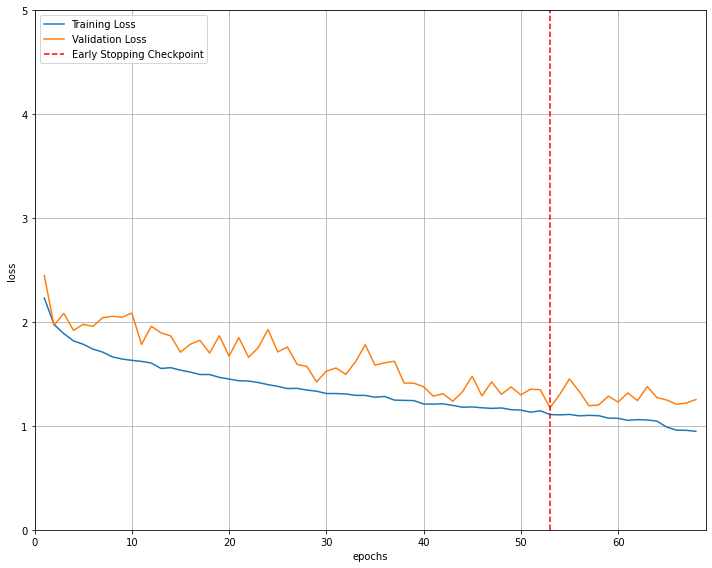

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = val_loss.index(min(val_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

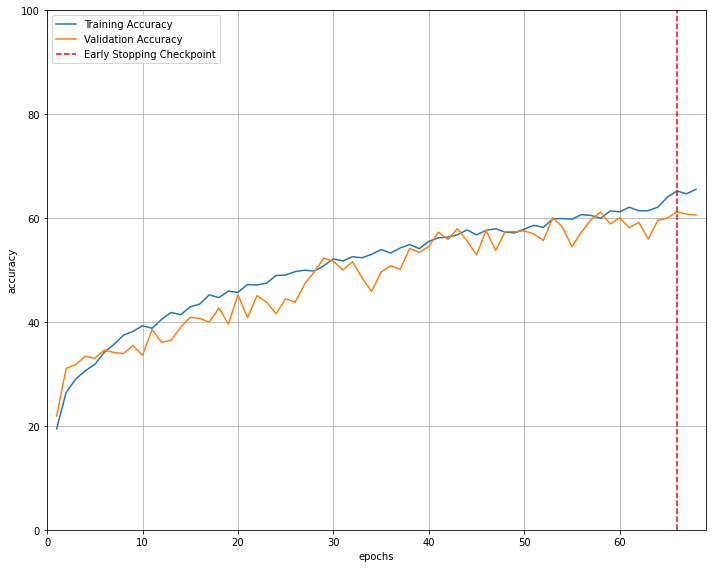

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, label='Training Accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label='Validation Accuracy')

# validation Accuracy의 최대값 지점을 찾기
maxposs = val_accuracy.index(max(val_accuracy))+1
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 100) # 일정한 scale
plt.xlim(0, len(train_accuracy)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('accuracy_plot.png', bbox_inches = 'tight')

In [ ]:
test(model, test_loader, criterion)

Epoch: 1. Validate.: 100%|██████████| 157/157 [00:10<00:00, 15.50it/s]


Test Loss: 1.2539, Accuracy: 60.62%


(1.253862076663971, 60.62)